In [38]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib

In [27]:
df = pd.read_csv('cs_bisnode_panel.csv')

In [17]:
#Chunk de utilização do pywedge após a limpeza da base
train = pd.read_csv('cs_bisnode_panel.csv')             #1 Base de dados utilizada
mc = pw.Pywedge_Charts(train, c=None, y = 'birth_year') #2 Puxa os dados e faz o target em uma variavel específica 
charts = mc.make_charts()                               #3 Cria os dados e gráficos @@@CUIDADO@@@ "Tempo de processamento"

/home/michelmcn/anaconda3/lib/python3.11/site-packages/pywedge/pywedge.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  self.X = self.train.drop(self.y,1)


#### Filtros:
Filtre para trabalhar apenas com empresas do ano de 2012
1 - Sales < 0 substituir por 0
Essa variável é bastante assimétrica, concorda? Será que vale criar novas
colunas que representem o valor emlo g dessa coluna?
Será que isso também se aplica para as demais?


In [4]:
# Contagem de Nulos
df.isnull()
null_count = df.isnull().sum()
print(null_count)


comp_id                      0
begin                        0
end                          0
COGS                    269572
amort                     8040
curr_assets                131
curr_liab                  131
extra_exp                18529
extra_inc                18529
extra_profit_loss        17203
finished_prod           270344
fixed_assets               131
inc_bef_tax               7437
intang_assets              140
inventories                131
liq_assets                 131
material_exp              8040
net_dom_sales           269572
net_exp_sales           269572
personnel_exp             8040
profit_loss_year          9884
sales                     7437
share_eq                   131
subscribed_cap             131
tang_assets               1470
wages                   269846
D                       287829
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             56457
exit_yea

## Pré Processamento
### 1- Drop das colunas

In [53]:
df = df.drop(columns=['COGS', 'finished_prod', 'net_dom_sales',
'net_exp_sales', 'wages', 'D'])


### 2- Instalar o pacote missingno para verificar o percentual de missings das features

<Axes: >

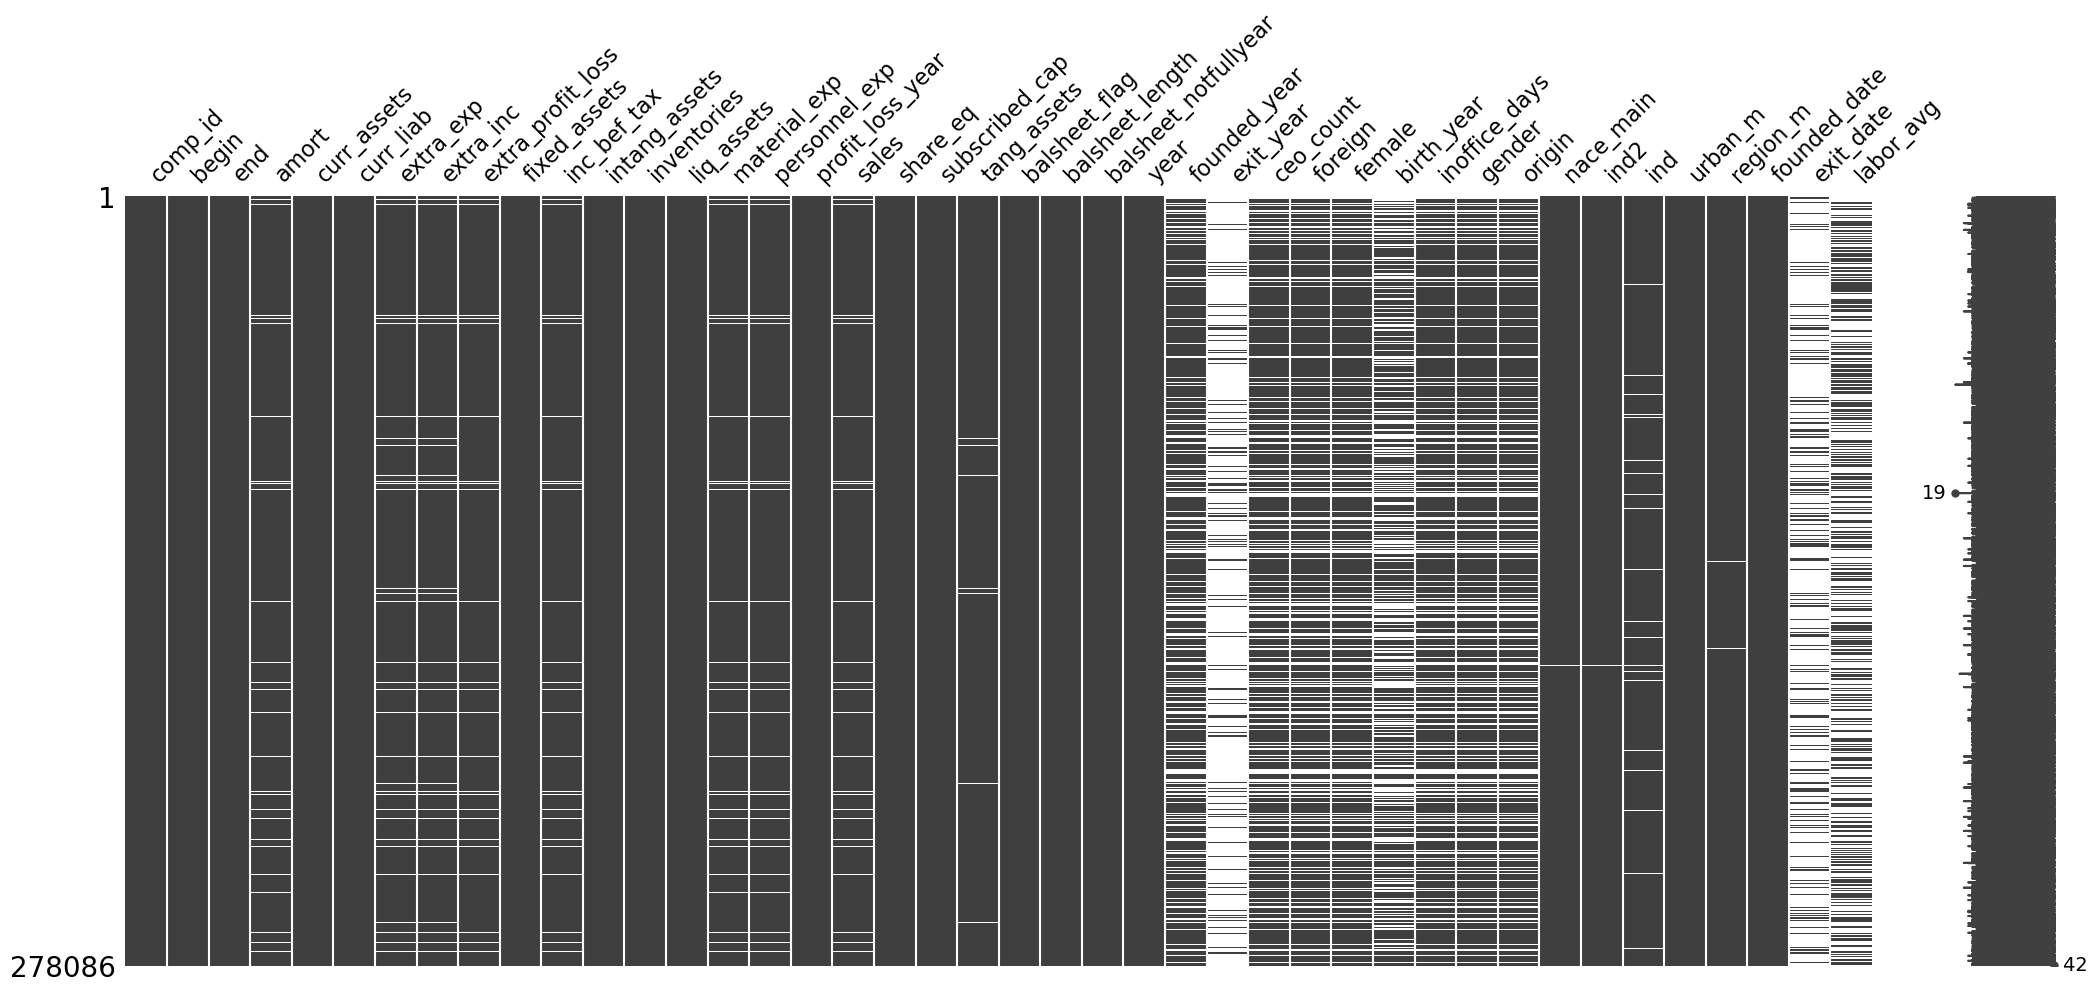

In [56]:
msno.matrix(df)

#### *Visualmente parece que as variáveis que apresentam missing values se coincidem no DF o que pode indicar algum grau de correlação.

### 3 - Remover os registros de 2016

In [55]:
df = df[df['year']!=2016]

In [58]:
#Cria uma coluna para verificar se a empresa esta ativa em 2012
df['Open_2012'] = df.groupby('comp_id')['year'].transform(lambda x: 2012 in x.values)

In [82]:
#Teste para contar quantas empresas estão abertas em 2012
test['comp_id'].nunique()

22845

In [81]:
test = df[['comp_id', 'year', 'sales', 'Open_2012']].query('(year == 2012) and (sales > 0)')
test.groupby('comp_id')['sales'].sum()



comp_id
1.001541e+06    1.203704e+03
1.002029e+06    1.136515e+06
1.003200e+06    2.785185e+03
1.011889e+06    4.336667e+05
1.014183e+06    1.297296e+05
                    ...     
4.638854e+11    1.561481e+05
4.639820e+11    1.908296e+05
4.640212e+11    3.804815e+04
4.640446e+11    8.533974e+06
4.641050e+11    1.548778e+05
Name: sales, Length: 22845, dtype: float64

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,Open_2012
0,1001034.0,2005-01-01,2005-12-31,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,...,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN,True
1,1001034.0,2006-01-01,2006-12-31,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,...,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN,True
2,1001034.0,2007-01-01,2007-12-31,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,...,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN,True
3,1001034.0,2008-01-01,2008-12-31,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,...,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN,True
4,1001034.0,2009-01-01,2009-12-31,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,...,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   amort                 279789 non-null  float64
 4   curr_assets           287698 non-null  float64
 5   curr_liab             287698 non-null  float64
 6   extra_exp             269300 non-null  float64
 7   extra_inc             269300 non-null  float64
 8   extra_profit_loss     270626 non-null  float64
 9   fixed_assets          287698 non-null  float64
 10  inc_bef_tax           280392 non-null  float64
 11  intang_assets         287689 non-null  float64
 12  inventories           287698 non-null  float64
 13  liq_assets            287698 non-null  float64
 14  material_exp          279789 non-null  float64
 15  

In [25]:
#Filtra as vendas >0
#Puxa apenas empresas abertas em 2012
#
df[(df['sales'] > 0) & (df['end'] >= '2012-01-01') & (df['begin'] <= '2012-12-31') & (df[''])]

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
14,1.001541e+06,2012-01-01,2012-12-31,NaN,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,...,male,Domestic,5610.0,56.0,3.0,3,Central,2008-02-24,NaN,NaN
23,1.002029e+06,2012-01-01,2012-12-31,NaN,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,...,male,Domestic,2711.0,27.0,2.0,3,East,2006-07-03,NaN,0.458333
35,1.003200e+06,2012-01-01,2012-12-31,NaN,25.925926,2.222222e+01,1.099630e+04,0.000000,0.000000,0.000000,...,female,Domestic,5630.0,56.0,3.0,1,Central,2003-10-21,2014-08-09,NaN
56,1.011889e+06,2012-01-01,2012-12-31,NaN,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,...,male,Domestic,5510.0,55.0,3.0,2,West,1992-11-09,NaN,1.621212
68,1.014183e+06,2012-01-01,2012-12-31,NaN,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,...,male,Domestic,5510.0,55.0,3.0,2,Central,2001-12-21,NaN,0.715278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287764,4.638854e+11,2012-01-01,2012-12-31,NaN,544.444458,1.437407e+04,1.330000e+04,0.000000,0.000000,0.000000,...,male,Domestic,4331.0,43.0,NaN,3,East,2009-02-25,NaN,0.121212
287779,4.639820e+11,2012-01-01,2012-12-31,NaN,16337.037109,3.140000e+04,8.300000e+03,0.000000,0.000000,0.000000,...,male,Domestic,2822.0,28.0,2.0,1,Central,1995-05-14,NaN,0.548611
287790,4.640212e+11,2012-01-01,2012-12-31,NaN,3566.666748,3.149630e+04,1.783704e+04,0.000000,0.000000,0.000000,...,male,Domestic,2822.0,28.0,2.0,2,Central,2006-05-09,NaN,0.083333
287798,4.640446e+11,2012-01-01,2012-12-31,1936285.125,76059.257812,4.776548e+06,1.297552e+06,0.000000,0.000000,0.000000,...,male,Foreign,3312.0,33.0,2.0,3,Central,2008-10-09,NaN,1.840278


,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
14,1.001541e+06,2012-01-01,2012-12-31,NaN,481.481476,9629.629883,1303.703735,0.000000,0.000000,0.000000,...,male,Domestic,5610.0,56.0,3.0,3,Central,2008-02-24,NaN,NaN
15,1.001541e+06,2013-01-01,2013-12-31,NaN,2292.592529,4811.111328,925.925903,0.000000,74.074074,74.074074,...,male,Domestic,5610.0,56.0,3.0,3,Central,2008-02-24,NaN,NaN
16,1.001541e+06,2014-01-01,2014-12-31,NaN,2292.592529,6500.000000,296.296295,0.000000,0.000000,0.000000,...,male,Domestic,5610.0,56.0,3.0,3,Central,2008-02-24,NaN,NaN
17,1.001541e+06,2015-01-01,2015-12-31,NaN,2292.592529,8729.629883,0.000000,0.000000,0.000000,0.000000,...,male,Domestic,5610.0,56.0,3.0,3,Central,2008-02-24,NaN,NaN
23,1.002029e+06,2012-01-01,2012-12-31,NaN,14929.629883,203885.187500,120444.453125,0.000000,0.000000,0.000000,...,male,Domestic,2711.0,27.0,2.0,3,East,2006-07-03,NaN,0.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287814,4.641050e+11,2012-01-01,2012-12-31,NaN,1311.111084,32614.814453,11048.148438,22.222221,0.000000,-22.222221,...,mix,Domestic,5610.0,56.0,3.0,3,West,1989-04-28,NaN,1.060606
287815,4.641050e+11,2013-01-01,2013-12-31,NaN,633.333313,39714.816406,13429.629883,0.000000,0.000000,0.000000,...,mix,Domestic,5610.0,56.0,3.0,3,West,1989-04-28,NaN,1.131944
287816,4.641050e+11,2014-01-01,2014-12-31,NaN,1088.888916,50096.296875,13755.555664,55.555557,0.000000,-55.555557,...,mix,Domestic,5610.0,56.0,3.0,3,West,1989-04-28,NaN,1.131944
287817,4.641050e+11,2015-01-01,2015-12-31,NaN,1288.888916,66385.187500,13751.851562,18.518518,0.000000,-18.518518,...,mix,Domestic,5610.0,56.0,3.0,3,West,1989-04-28,NaN,1.138889
